# Agenda

1. Backgrounds/Data
2. Question 1-5
3. Conclusions

## Backgrounds/Data

1. Goal: detect ambient temperature system failure;
2. Data: univariate time series;
3. technology applied: anomaly detection;

In [1]:
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv',
                parse_dates=['timestamp']).set_index('timestamp').sort_index()

## Question 1-5

### Question 1: EDA



* 5 steps

#### step 1

In [3]:
df.shape

(7267, 1)

In [4]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


#### step 2: check distribution

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

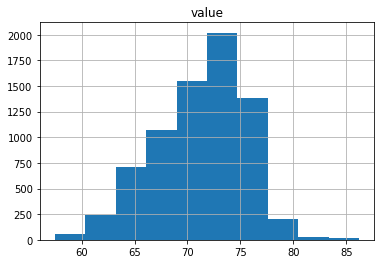

In [5]:
df.hist()

#### transform to normal distribution

* we will depend on z-score for anamoly detection. So normal distribution is a necesity
* making sure your data is normaly distributed help stochastic gradient descent converge more effectively

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

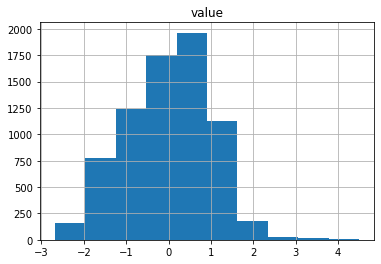

In [6]:
df_transform = pd.DataFrame(power_transform(df, method='box-cox'),index=df.index,
            columns=['value'])

df_transform.hist()

#### step 3: check frequency and linear interpolate fill missing values

**Note: missing values are random? Are they missing due to some system failure?**

In [7]:
df_full = pd.DataFrame({'timestamp':pd.date_range(start=df.index[0], end=df.index[-1],freq='H')}
            ).set_index('timestamp').join(df)
df_full.shape
df_full['value'] = df_full['value'].interpolate(method='linear')

#### step 4: check stationarity - a constant mean and a constant variance.


**Stationarity is a time series property. And it is the prerequisite for almost all the time series analysis and modeling.**

* The series is stationary - the trend is fixed and there is no seasonality. 
* although test says it is stationary. We will still create differencing features. 



<AxesSubplot:xlabel='timestamp'>

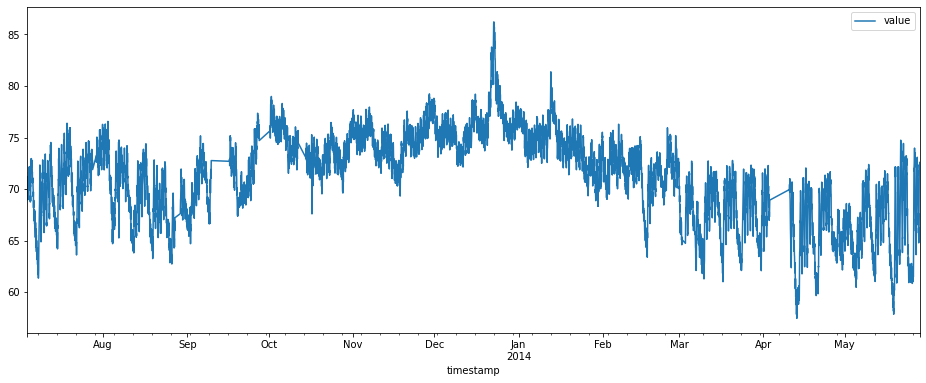

In [8]:
df_full.plot(figsize=(16,6))

#### Augmented Dickey-Fuller (ADF) Test

null hypothesis: it is non-stationary

In [9]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.517563
p-value: 0.000002
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### step 5: check autocorrelation
(The analysis of autocorrelation helps to find repeating periodic patterns)
* highly significant autocorrelation detected 
* autocorrelation coefficient locally peaks around same hour

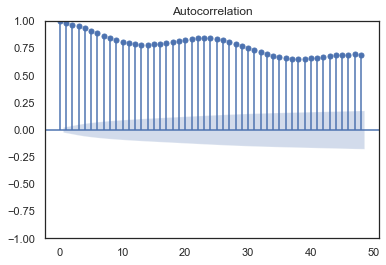

In [49]:
plot_acf(df.values.squeeze(),lags=24*2)
plt.show()

### Question 2: Feature Engineering

**Cat1: same hour**
* same hour trend extraction of temperature in 3-day, 7-day and 4-week windows.(same_hour_rolling_mean_df
* same hour fluctuation extraction of temperature in 3-day, 7-day and 4-week windows. (same_hour_rolling_std_df

* same hour trend extraction of temperature change in 3-day, 7-day and 4-week windows.(same_hour_diff_rolling_mean_df
* same hour volatility extraction of temperature change in 7-day and 4-week windows.(same_hour_diff_rolling_std_df

**window:**
1. 3-day (short-term)
2. 7-day (medium-term)
3. 4-week (long-term)

---------------

**Cat2: consecutive hour**
* trend extraction of temperature in consecutive windows.(consecutive_hour_mean_df
* fluctuation extraction of temperature in consecutive windows.(consecutive_hour_std_df
* trend extraction of temperature change in consecutive windows.(consecutive_hour_diff_mean_df
* volatility extraction of temperature change in consecutive windows.(consecutive_hour_diff_std_df 

**window:**
1. 6 hour (recent hours)
2. 12 hour (daytime/nighttime)
3. 24-hour (one-day)

---------------

**window size can be changed/tuned based on domain knowledge**

In [11]:
rolling_days = [3, 7, 28]
list_rolling_df = []
list_rolling_diff_df = []

list_rolling_std_df = []
list_rolling_diff_std_df = []

for rolling_day in rolling_days:
    list_rolling_df_i = []
    list_rolling_df_i_std = []
    list_rolling_df_j = []
    list_rolling_df_j_std = []
    for hr in range(24):
        tmp = df_full.iloc[hr::24, :].rolling(rolling_day).mean()
        tmp.columns=['same_hour_past_'+str(rolling_day)+'_days_rolling_mean']
        list_rolling_df_i.append(tmp)
        
        tmp = df_full.iloc[hr::24, :].rolling(rolling_day).std()
        tmp.columns=['same_hour_past_'+str(rolling_day)+'_days_rolling_std']
        list_rolling_df_i_std.append(tmp)
        
        tmp = df_full.iloc[hr::24, :].diff().rolling(rolling_day).mean()
        tmp.columns=['same_hour_diff_past_'+str(rolling_day)+'_days_rolling_mean']
        list_rolling_df_j.append(tmp)
        
        tmp = df_full.iloc[hr::24, :].diff().rolling(rolling_day).std()
        tmp.columns=['same_hour_diff_past_'+str(rolling_day)+'_days_rolling_std']
        list_rolling_df_j_std.append(tmp)
        
        
    rolling_mean_past_df = pd.concat(list_rolling_df_i,axis=0).sort_index()
    rolling_mean_diff_past_df = pd.concat(list_rolling_df_j,axis=0).sort_index()
    
    rolling_std_past_df = pd.concat(list_rolling_df_i_std,axis=0).sort_index()
    rolling_std_diff_past_df = pd.concat(list_rolling_df_j_std,axis=0).sort_index()
    
    
    list_rolling_df.append(rolling_mean_past_df)
    list_rolling_diff_df.append(rolling_mean_diff_past_df)
    
    list_rolling_std_df.append(rolling_std_past_df)
    list_rolling_diff_std_df.append(rolling_std_diff_past_df)
    
same_hour_rolling_mean_df = pd.concat(list_rolling_df,axis=1).sort_index()
same_hour_diff_rolling_mean_df = pd.concat(list_rolling_diff_df,axis=1).sort_index()

same_hour_rolling_std_df = pd.concat(list_rolling_std_df,axis=1).sort_index()
same_hour_diff_rolling_std_df = pd.concat(list_rolling_diff_std_df,axis=1).sort_index()

In [12]:
rolling_hours =[6,12,24]
list_rolling_df = []
list_rolling_diff_df = []

list_rolling_std_df = []
list_rolling_diff_std_df = []

for hr in rolling_hours:
    tmp = df_full.rolling(hr).mean()
    tmp.columns=['past_'+str(hr)+'_hrs_rolling_mean']
    list_rolling_df.append(tmp)
    
    tmp = df_full.diff().rolling(hr).mean()
    tmp.columns=['past_'+str(hr)+'_hrs_diff_rolling_mean']
    list_rolling_diff_df.append(tmp)
    
    tmp = df_full.rolling(hr).std()
    tmp.columns=['past_'+str(hr)+'_hrs_rolling_std']
    list_rolling_std_df.append(tmp)
    
    tmp = df_full.diff().rolling(hr).std()
    tmp.columns=['past_'+str(hr)+'_hrs_diff_rolling_std']
    list_rolling_diff_std_df.append(tmp)
    
consecutive_hour_mean_df = pd.concat(list_rolling_df,axis=1).sort_index()
consecutive_hour_diff_mean_df = pd.concat(list_rolling_diff_df,axis=1).sort_index()

consecutive_hour_std_df = pd.concat(list_rolling_std_df,axis=1).sort_index()
consecutive_hour_diff_std_df = pd.concat(list_rolling_diff_std_df,axis=1).sort_index()

In [13]:
fea_eng_df = pd.concat([same_hour_rolling_mean_df,same_hour_diff_rolling_mean_df,
                        same_hour_rolling_std_df, same_hour_diff_rolling_std_df,
          consecutive_hour_mean_df,consecutive_hour_diff_mean_df,
          consecutive_hour_std_df,consecutive_hour_diff_std_df],axis=1)

#### there are some correlations - we may want to do feature selection/dimension reduction for following modelling (expected due to autocorrelation)

<AxesSubplot:>

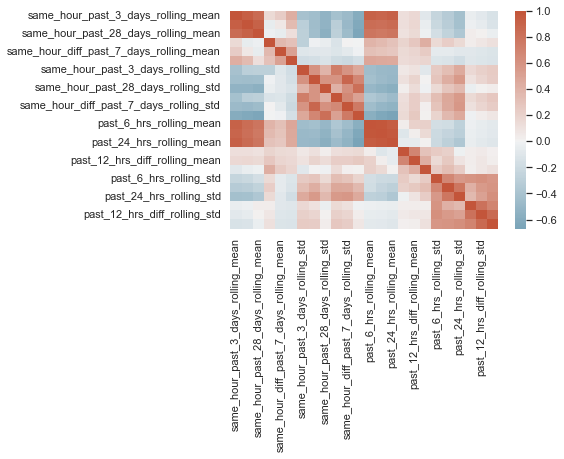

In [14]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(fea_eng_df.corr(),center=0,cmap=cmap)

#### Four types of features:
* Trend extraction of temperature (same_hour_rolling_mean_df,consecutive_hour_mean_df)
* Fluctuation extraction of temperature (same_hour_rolling_std_df, consecutive_hour_std_df
* Trend extraction of temperature change (same_hour_diff_rolling_mean_df,consecutive_hour_diff_mean_df
* voliatility extraction of temperature change (same_hour_diff_rolling_std_df,consecutive_hour_diff_std_df

#### Temperature trend 
* steadily increase from sep to Jan;
* peak between Jan and Feb
* decrease after Feb
* bottom between Apr and May

<AxesSubplot:xlabel='timestamp'>

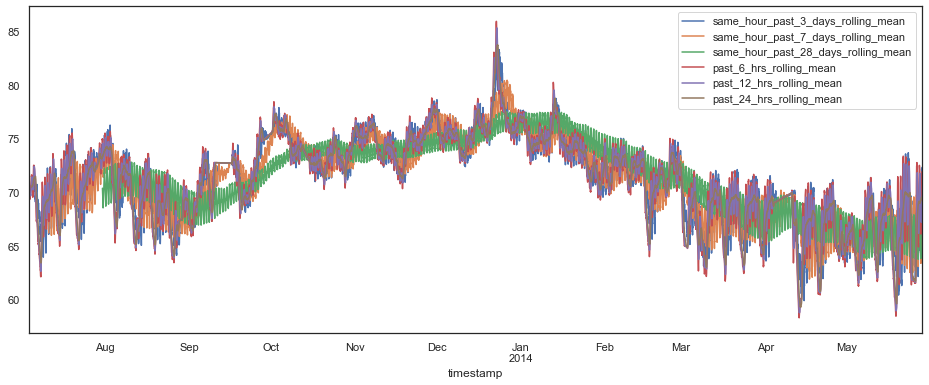

In [15]:
pd.concat([same_hour_rolling_mean_df,consecutive_hour_mean_df],axis=1).plot(figsize=(16,6))

#### Temperature fluctuation 
* temperature fluctuates the most between March and May
* temperature most stable between Nov and Dec

<AxesSubplot:xlabel='timestamp'>

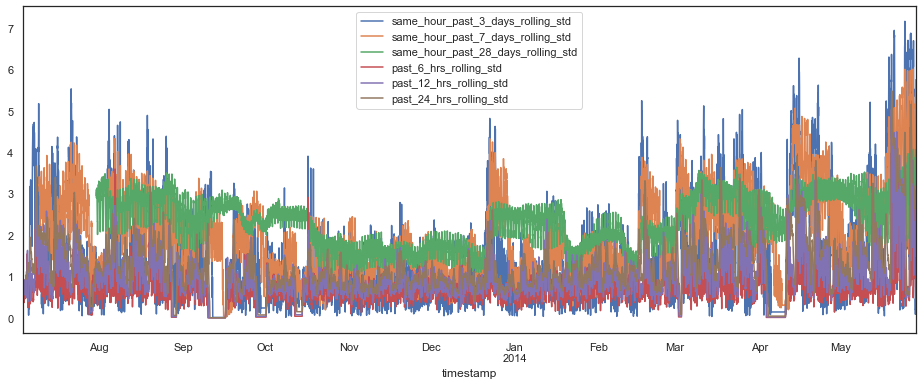

In [16]:
pd.concat([same_hour_rolling_std_df, consecutive_hour_std_df],axis=1).plot(figsize=(16,6))

#### Temperature change trend

* temperature can be over 4 degrees different compare to recent same hours around May
* between Oct to March, it is common to have smaller than 2 degree difference in recent same hour temperature 
* between July to Oct, temperature difference in recent same hour usually range from 2 to 4

<AxesSubplot:xlabel='timestamp'>

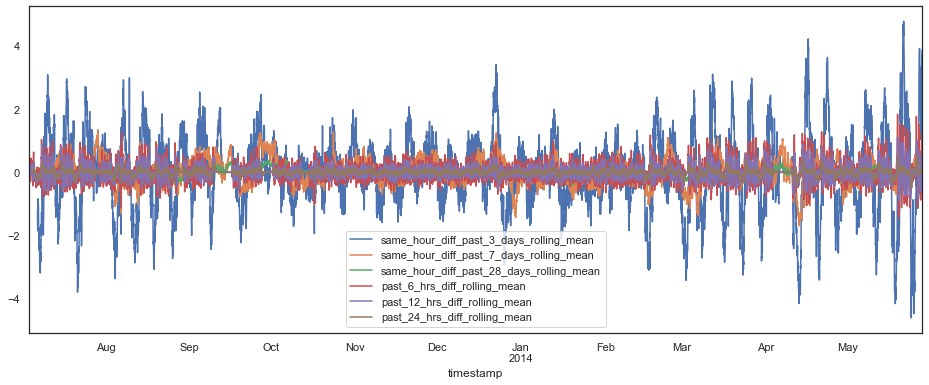

In [17]:
pd.concat([same_hour_diff_rolling_mean_df,consecutive_hour_diff_mean_df],axis=1).plot(figsize=(16,6))

#### Temperature change volatility 

* temperature change between March and May is not as predictable as from Oct to Feb 

<AxesSubplot:xlabel='timestamp'>

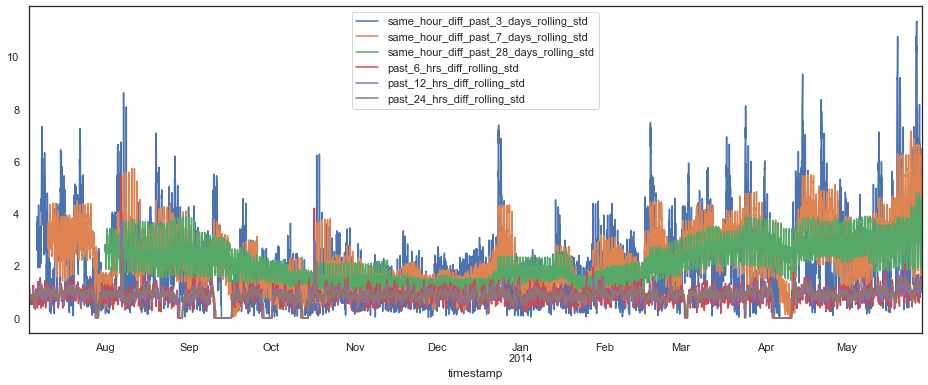

In [18]:
pd.concat([same_hour_diff_rolling_std_df,consecutive_hour_diff_std_df],axis=1).plot(figsize=(16,6))

### Question 3: Statistical Modeling

* Definition of outliers: 
    * level value is more than 2 standard deviations away from trend mean 
* Assumptions:
    * The distribution of hourly temperature in rolling 24 hours/one week/4 weeks/the whole period is sampled from normal distribution (captures short term, medium term and long term) 
    
    
**NOTE:
if our distribution is not normal, we can use robust z-score method - MAD (median absolute deviation**


In [19]:
## rolling zscore
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [20]:
#use df_transform
df_q3 = zscore(df_transform, 24).replace([np.inf, -np.inf], np.nan).rename(columns={'value':'zscore_rolling_1day'}).join(
    zscore(df_transform, 24*7)).replace([np.inf, -np.inf], np.nan).rename(columns={'value':'zscore_rolling_1week'}).join(
    zscore(df_transform, 24*7*4)).replace([np.inf, -np.inf], np.nan).rename(columns={'value':'zscore_rolling_4weeks'}).join(
    stats.zscore(df_transform).replace([np.inf, -np.inf], np.nan).rename(columns={'value':'zscore_whole_period'})
                                                                      ).abs()

df_q3_outlier = (df_q3>2).sum(axis=1)

## v1: as long as the value exceeds one out of three 
df_q3_answer_v1 = df_q3.loc[df_q3_outlier[df_q3_outlier>0].index]
df_q3_answer_v1.shape

(1428, 4)

In [21]:
df_q3_answer_v1.shape[0]/df_full.shape[0]

0.1810344827586207

In [22]:
## v2: as long as the value exceeds two out of three 

df_q3_answer_v2 = df_q3.loc[df_q3_outlier[df_q3_outlier>1].index]
df_q3_answer_v2.shape

(463, 4)

In [23]:
df_q3_answer_v2.shape[0]/df_full.shape[0]

0.058696754563894525

In [24]:
## v2: the value exceeds all

df_q3_answer_v3 = df_q3.loc[df_q3_outlier[df_q3_outlier>2].index]
df_q3_answer_v3.shape

(150, 4)

In [25]:
df_q3_answer_v3.shape[0]/df_full.shape[0]

0.019016227180527385

In [26]:
statis_label_df = (df_q3_outlier>0).to_frame().rename(columns={0:'statis_v1_outlier'}).join(
(df_q3_outlier>1).to_frame().rename(columns={0:'statis_v2_outlier'})).join(
(df_q3_outlier>2).to_frame().rename(columns={0:'statis_v3_outlier'})
)

### Question 4: clustering
* assumption:
    * outlier definition
    * DBSCAN model assumption: Normal points occur in dense regions, while anomalies occur in sparse regions.
        * details: clusters are dense regions in space separated by regions of lower density. It groups ‘densely grouped’ data points into a single cluster. It can identify clusters in large spatial datasets by looking at the local density of the data points. 
        * The most exciting feature of DBSCAN clustering is that it is robust to outliers. It also does not require the number of clusters to be told beforehand, unlike K-Means, where we have to specify the number of centroids.
        * DBSCAN requires only two parameters: epsilon and minPoints. Epsilon is the radius of the circle to be created around each data point to check the density and minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point.
        
        
**Why DBSCAN:**

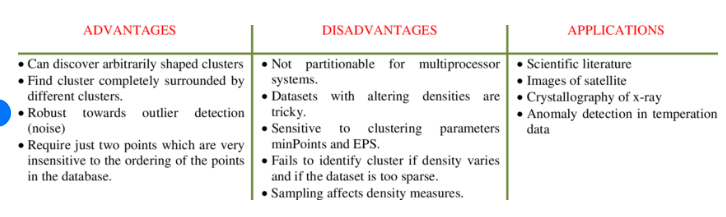

In [27]:
Image(filename='DBSCAN.png') 

In [28]:
feature_df = df_q3.join(fea_eng_df,how='left')
feature_df.describe()

,zscore_rolling_1day,zscore_rolling_1week,zscore_rolling_4weeks,zscore_whole_period,same_hour_past_3_days_rolling_mean,same_hour_past_7_days_rolling_mean,same_hour_past_28_days_rolling_mean,same_hour_diff_past_3_days_rolling_mean,same_hour_diff_past_7_days_rolling_mean,same_hour_diff_past_28_days_rolling_mean,...,past_24_hrs_rolling_mean,past_6_hrs_diff_rolling_mean,past_12_hrs_diff_rolling_mean,past_24_hrs_diff_rolling_mean,past_6_hrs_rolling_std,past_12_hrs_rolling_std,past_24_hrs_rolling_std,past_6_hrs_diff_rolling_std,past_12_hrs_diff_rolling_std,past_24_hrs_diff_rolling_std
count,7243.000000,7099.000000,6595.000000,7267.000000,7219.000000,7123.000000,6651.000000,7195.000000,7099.000000,6627.000000,...,7244.000000,7261.000000,7255.000000,7243.000000,7262.000000,7256.000000,7244.000000,7261.000000,7255.000000,7243.000000
mean,1.047882,0.947068,0.888588,0.813545,71.260506,71.344267,71.675878,-0.018521,-0.023151,-0.021108,...,71.258415,-0.001137,-0.001187,-0.000774,0.786013,1.065570,1.366843,0.888506,0.899083,0.908664
std,0.766512,0.685256,0.711728,0.581542,3.949345,3.696260,3.378368,1.184087,0.374653,0.120416,...,3.968523,0.334481,0.230615,0.098724,0.377619,0.554271,0.678410,0.305128,0.234581,0.198631
min,0.000726,0.000388,0.000088,0.000209,59.899770,61.906840,63.755057,-4.604380,-1.698793,-0.421437,...,59.290676,-1.444149,-0.886724,-0.497247,0.000821,0.001582,0.003103,0.000000,0.000000,0.000000
25%,0.462043,0.402530,0.345844,0.339606,68.212440,68.305156,68.968021,-0.715212,-0.250500,-0.094333,...,68.634558,-0.220267,-0.146968,-0.049777,0.559687,0.702317,0.901846,0.698961,0.770147,0.807924
50%,0.927523,0.837914,0.723737,0.730601,71.720227,71.629577,72.232187,0.022542,-0.024123,-0.020006,...,71.736950,-0.031121,-0.020356,0.004317,0.708158,0.908994,1.172556,0.880842,0.889085,0.897065
75%,1.480643,1.341111,1.273910,1.177299,74.338623,74.427529,74.403323,0.680687,0.220173,0.056184,...,74.344020,0.180607,0.131831,0.051044,0.911822,1.251838,1.692403,1.057069,1.010481,0.982125
max,12.264330,5.384993,5.876516,4.497689,83.295376,80.440385,77.497598,4.766051,1.266828,0.403048,...,83.734300,1.829803,1.091136,0.525489,3.974965,5.026409,5.484280,5.435163,3.718865,2.672148


<AxesSubplot:>

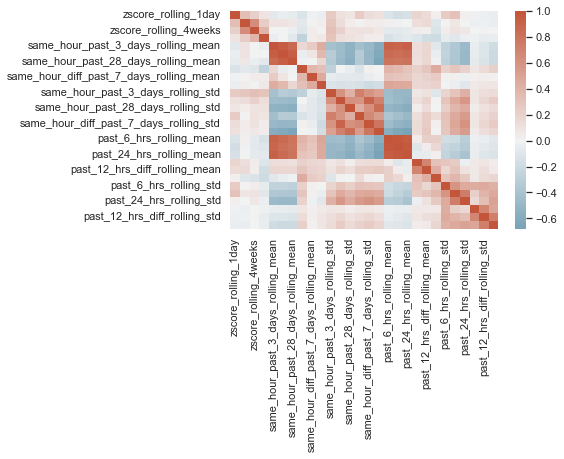

In [29]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(feature_df.corr(),center=0,cmap=cmap)

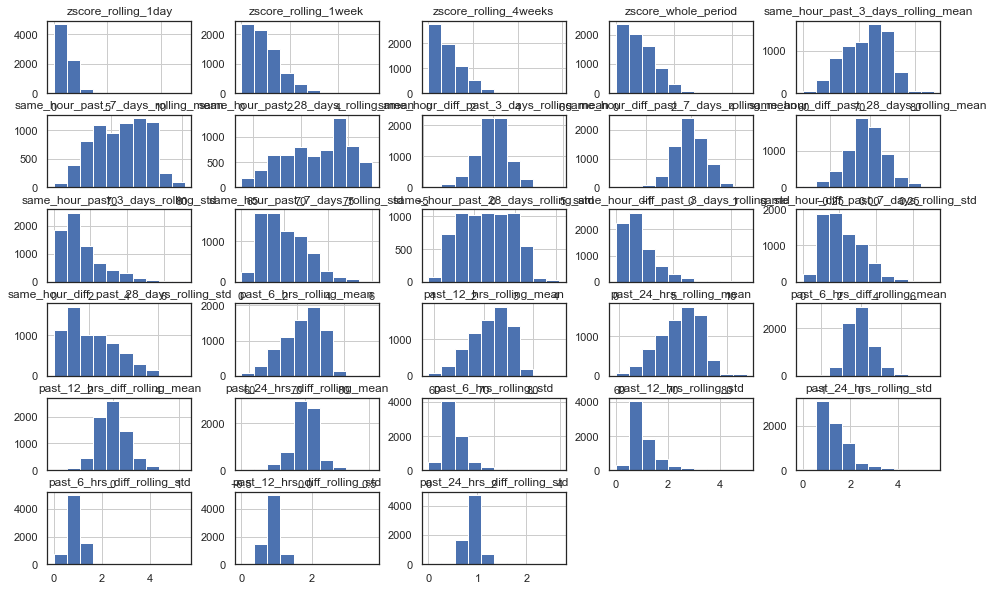

In [30]:
ax = feature_df.hist(figsize=(16,10))

In [31]:
#default for DBSCAN distance metric: euclidean
feature_df = feature_df.fillna(feature_df.mean())

## Standardizing data is recommended 
## because otherwise the range of values in each feature 
## will act as a weight when determining how to cluster data, 
## which is typically undesired.

### from distributions above, there are outlier values for some feature


###This Scaler removes the median and 
### scales the data according to the quantile range 
X = RobustScaler().fit_transform(feature_df.values)

In [32]:
###reduce dimension and multicollinearity

##Clustering analysis is not negatively affected by heteroscedasticity 
##but the results are negatively impacted by multicollinearity of features/ variables
##as the correlated feature/ variable will carry extra weight 
##on the distance calculation than desired.

###speed up computation

pca = PCA(n_components=15) #discretionary 15
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_.sum())

0.9377901488730215


In [33]:
df_q4 = df_q3.join(fea_eng_df)

###eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
for eps in range(1,10):
    clustering =DBSCAN(eps=eps,min_samples=1).fit(X) 
    df_q4['DBSCAN_label'] = clustering.labels_
    outlier_group_no = df_q4[['zscore_rolling_1day','DBSCAN_label']].groupby('DBSCAN_label').count(
).sort_values('zscore_rolling_1day').iloc[:-1].index
    q4_outlier_hours = df_q4[df_q4['DBSCAN_label'].isin(outlier_group_no)].index
    print(len(q4_outlier_hours),len(q4_outlier_hours)/df_q4.shape[0])

7197 0.9903674143387918
516 0.07100591715976332
93 0.012797578092748039
52 0.007155635062611807
49 0.006742809962845741
9 0.0012384752992981973
3 0.00041282509976606576
3 0.00041282509976606576
0 0.0


In [34]:
### discretionary eps=2
clustering =DBSCAN(eps=2,min_samples=1).fit(X) 
df_q4['DBSCAN_label'] = clustering.labels_
outlier_group_no = df_q4[['zscore_rolling_1day','DBSCAN_label']].groupby('DBSCAN_label').count(
).sort_values('zscore_rolling_1day').iloc[:-1].index
q4_outlier_hours = df_q4[df_q4['DBSCAN_label'].isin(outlier_group_no)].index
print(len(q4_outlier_hours),len(q4_outlier_hours)/df_q4.shape[0])
feature_df['DBSCAN_outlier'] = df_q4['DBSCAN_label'].isin(outlier_group_no)

516 0.07100591715976332


### Question 5: classification
* **NearestNeighbors:** 
    * Outlier definition: nearest neighbor distance over 90% quantile
    * model assumption: distance metric accurately measures data similarity. Normal point is close to its neighbors and anomaly is far from its neighbors. 
    * we can try different distance metrics.
    
* **IsolationForest:** 
    * no assumption: Isolation Forest detects anomalies purely based on the concept of isolation without employing any distance or density measure — fundamentally different from all existing methods.
    * details:
        1. Random and recursive partition of data is carried out, which is represented as a tree (random forest). This is the training stage where the user defines the parameters of the subsample and the number of trees.
        2. The end of the tree is reached once the recursive partition of data is finished. It is expected that the distance taken to reach the outlier is far less than that for the normal data.
        3. The distance of the path is averaged and normalized to calculate the anomaly score. The judgment of the outlier is carried out on the basis of the score.

In [35]:
##default distance metric: minkowski
## a metric in a normed vector space 
## which can be considered as a generalization of both the Euclidean distance and the Manhattan distance. 
neigh = NearestNeighbors(n_neighbors=2) #the closest neighbor is self
neigh.fit(X)

NearestNeighbors(n_neighbors=2)

In [36]:
feature_df['nn_distance'] = neigh.kneighbors(X)[0][:,1]

In [37]:
feature_df['nn_distance'].describe()

count    7267.000000
mean        1.097302
std         0.363646
min         0.082011
25%         0.874365
50%         1.052541
75%         1.260661
max         8.901086
Name: nn_distance, dtype: float64

In [38]:
decided_quantile = .9 #discretionary
q5_outlier_hours = feature_df[feature_df['nn_distance']>feature_df['nn_distance'].quantile(decided_quantile)].index
feature_df['nn_outlier'] = feature_df['nn_distance']>feature_df['nn_distance'].quantile(decided_quantile)
len(q5_outlier_hours)

727

In [39]:
clf = IsolationForest(random_state=0).fit_predict(X)
feature_df['isoForest_label']=clf

In [40]:
outlier_group_no = feature_df[['zscore_rolling_1day','isoForest_label']].groupby('isoForest_label').count(
).sort_values('zscore_rolling_1day').iloc[:-1].index

In [41]:
q5_outlier_hours_v2 = feature_df[feature_df['isoForest_label'].isin(outlier_group_no)].index
feature_df['isoforest_outlier'] = feature_df['isoForest_label'].isin(outlier_group_no)
len(q5_outlier_hours_v2)

431

## Conclusions 

* 6 versions of outliers detected from 6 different methods.
* isolation forest seems to work the best based on correlations with other methods
* can apply majority vote for final decisions


if we can collect more data points:

    * ARIMA/SARIMA is another statistical way worthy of trying.
    
    * autoencoder is also another ML way worthy of trying.
    
    (AutoEncoder is a generative unsupervised deep learning algorithm used for reconstructing high-dimensional input data using a neural network with a narrow bottleneck layer in the middle which contains the latent representation of the input data)

In [42]:
all_version_label_df = feature_df.join(statis_label_df).filter(like='outlier')

In [43]:
all_version_label_df.corr()

,DBSCAN_outlier,nn_outlier,isoforest_outlier,statis_v1_outlier,statis_v2_outlier,statis_v3_outlier
DBSCAN_outlier,1.000000,0.364944,0.647374,0.158574,0.096795,0.118135
nn_outlier,0.364944,1.000000,0.292953,0.166362,0.066998,0.054815
isoforest_outlier,0.647374,0.292953,1.000000,0.189584,0.168259,0.164325
statis_v1_outlier,0.158574,0.166362,0.189584,1.000000,0.527489,0.293564
statis_v2_outlier,0.096795,0.066998,0.168259,0.527489,1.000000,0.556530
statis_v3_outlier,0.118135,0.054815,0.164325,0.293564,0.556530,1.000000


In [44]:
all_version_label_df.corr().mean()

DBSCAN_outlier       0.397637
nn_outlier           0.324345
isoforest_outlier    0.410416
statis_v1_outlier    0.389262
statis_v2_outlier    0.402678
statis_v3_outlier    0.364561
dtype: float64

<AxesSubplot:>

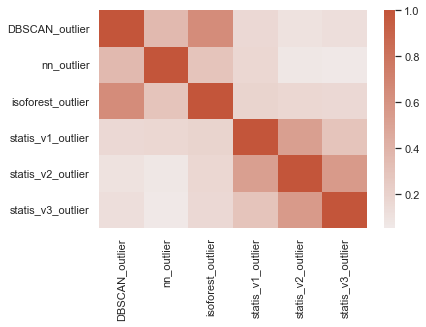

In [45]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(all_version_label_df.corr(),center=0,cmap=cmap)

In [46]:
### 72% of the data is considered as non-outlier by all methods
(all_version_label_df.sum(axis=1)==0).sum()/all_version_label_df.shape[0]

0.7183156735929545

<AxesSubplot:>

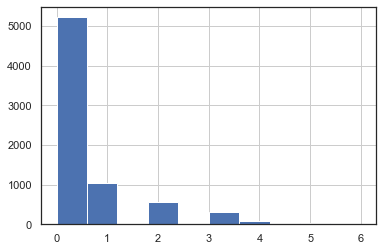

In [47]:
all_version_label_df.sum(axis=1).hist()

In [48]:
all_version_label_df.sum(axis=1).max()

6